# Create some visualizations of the region
**Author:** Andy Barrett

In [2]:
%pip install cmocean

  Using cached cmocean-4.0.3-py3-none-any.whl.metadata (4.2 kB)
Using cached cmocean-4.0.3-py3-none-any.whl (421 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np

import xarray as xr
import hvplot.xarray

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, BoundaryNorm
import cmocean

In [28]:
ds = xr.open_zarr("~/shared-public/mind_the_chl_gap/IO.zarr")

In [29]:
ds

<xarray.Dataset> Size: 66GB
Dimensions:                       (time: 16071, lat: 177, lon: 241)
Coordinates:
  * lat                           (lat) float32 708B 32.0 31.75 ... -11.75 -12.0
  * lon                           (lon) float32 964B 42.0 42.25 ... 101.8 102.0
  * time                          (time) datetime64[ns] 129kB 1979-01-01 ... ...
Data variables: (12/27)
    CHL                           (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_cmes-cloud                (time, lat, lon) uint8 686MB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_cmes-gapfree              (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_cmes-land                 (lat, lon) uint8 43kB dask.array<chunksize=(177, 241), meta=np.ndarray>
    CHL_cmes-level3               (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_cmes_flags-gapfree        (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    ...                            ...
    ug_curr                       (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    v_curr                        (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    v_wind                        (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    vg_curr                       (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    wind_dir                      (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    wind_speed                    (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L3_MY_009_103
    ...                              ...
    time_coverage_end:               2024-04-18T02:58:23Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-04-16T21:12:05Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l3-mult...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0

In [30]:
ds.lat.size * ds.lon.size

42657

## Plot bathymetry

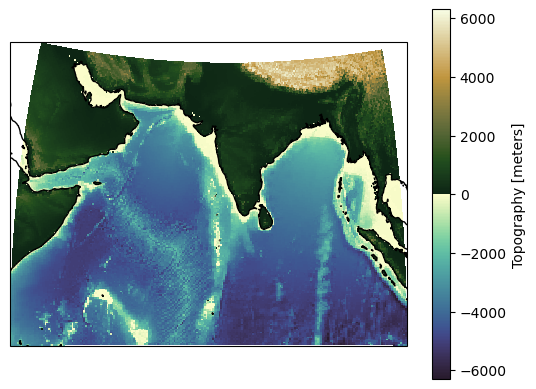

In [39]:
projection = ccrs.Stereographic(central_longitude=75., central_latitude=10.)
ax = ds.topo.plot(transform=ccrs.PlateCarree(), 
                                     subplot_kws=dict(projection=projection),
                                     cmap=cmocean.cm.topo)
ax.axes.coastlines()

## Plot climatology of cloud cover by month

A first klugey effort

In [32]:
idx = (ds.CHL.isnull().sum(dim=["lat","lon"]) < (ds.lat.size * ds.lon.size)).compute()
ds = ds.sel(time=ds.time[idx])

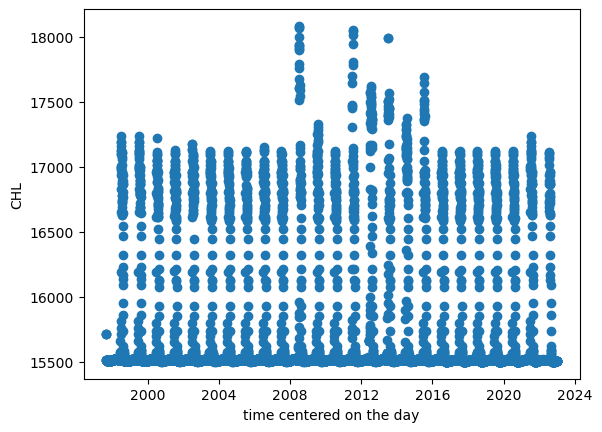

In [33]:
ds.CHL.isnull().sum(dim=["lat","lon"]).plot(marker='o', ls="")

In [50]:
chl_count = ds.CHL.isnull().groupby(ds.time.dt.month).sum() / ds.CHL.groupby(ds.time.dt.month).count()

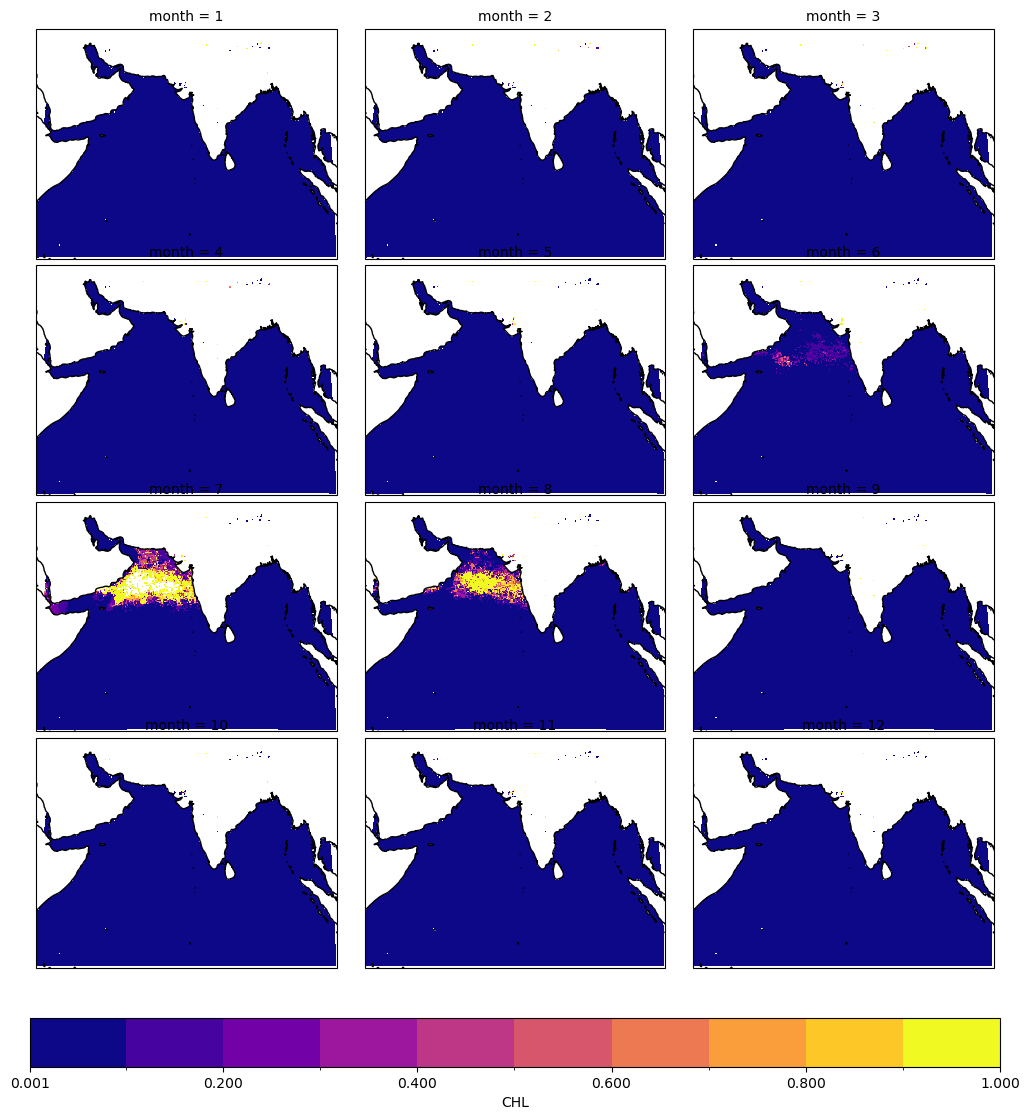

In [54]:
bounds = [0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]  #np.arange(0,1.1,0.1)
norm = BoundaryNorm(bounds, ncolors=256, clip=True)
p = chl_count.plot(
    col="month", 
    col_wrap=3, 
    norm=norm, 
    cmap="plasma",
    transform=ccrs.PlateCarree(),
    subplot_kws=dict(
        projection=projection,
    ),
    cbar_kwargs=dict(
        orientation="horizontal", 
        spacing="proportional", 
        extend="neither"),
    )
#[ax.axes.add_feature(cfeature.LAND) for ax in p.axs.flat];
[ax.axes.coastlines() for ax in p.axs.flat];
p.fig.subplots_adjust(bottom=0.2)
# plt.tight_layout()

## Plot climatologies

- Winds
- SST
- CHL
- Currents

In [56]:
ds_mon = ds.resample({"time":'MS'}).mean()
ds_clm = ds_mon.groupby(ds_mon.time.dt.month).mean()

In [57]:
ds_clm

<xarray.Dataset> Size: 61MB
Dimensions:                       (month: 12, lat: 177, lon: 241)
Coordinates:
  * lat                           (lat) float32 708B 32.0 31.75 ... -11.75 -12.0
  * lon                           (lon) float32 964B 42.0 42.25 ... 101.8 102.0
  * month                         (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables: (12/27)
    CHL                           (month, lat, lon) float32 2MB dask.array<chunksize=(3, 177, 241), meta=np.ndarray>
    CHL_cmes-cloud                (month, lat, lon) float64 4MB dask.array<chunksize=(3, 177, 241), meta=np.ndarray>
    CHL_cmes-gapfree              (month, lat, lon) float32 2MB dask.array<chunksize=(3, 177, 241), meta=np.ndarray>
    CHL_cmes-level3               (month, lat, lon) float32 2MB dask.array<chunksize=(3, 177, 241), meta=np.ndarray>
    CHL_cmes_flags-gapfree        (month, lat, lon) float32 2MB dask.array<chunksize=(3, 177, 241), meta=np.ndarray>
    CHL_cmes_flags-level3         (month, lat, lon) float32 2MB dask.array<chunksize=(3, 177, 241), meta=np.ndarray>
    ...                            ...
    v_wind                        (month, lat, lon) float32 2MB dask.array<chunksize=(3, 177, 241), meta=np.ndarray>
    vg_curr                       (month, lat, lon) float32 2MB dask.array<chunksize=(3, 177, 241), meta=np.ndarray>
    wind_dir                      (month, lat, lon) float32 2MB dask.array<chunksize=(3, 177, 241), meta=np.ndarray>
    wind_speed                    (month, lat, lon) float32 2MB dask.array<chunksize=(3, 177, 241), meta=np.ndarray>
    CHL_cmes-land                 (month, lat, lon) float64 4MB dask.array<chunksize=(12, 177, 241), meta=np.ndarray>
    topo                          (month, lat, lon) float64 4MB dask.array<chunksize=(12, 177, 241), meta=np.ndarray>
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L3_MY_009_103
    ...                              ...
    time_coverage_end:               2024-04-18T02:58:23Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-04-16T21:12:05Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l3-mult...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0

## Chlorophyl

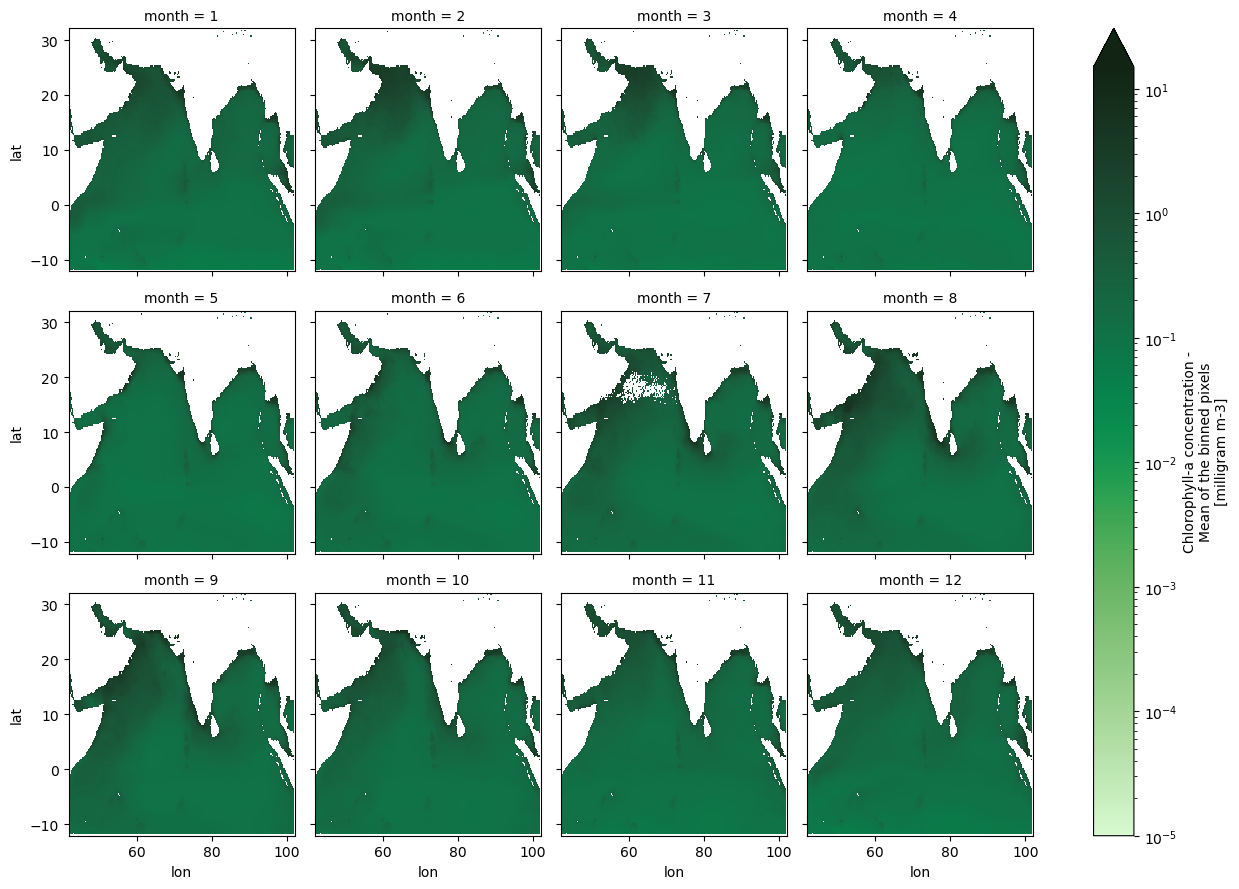

In [61]:
norm = LogNorm(vmin=0.00001, vmax=15., clip=True)
ds_clm["CHL_cmes-gapfree"].plot(col="month", col_wrap=4, norm=norm, cmap=cmocean.cm.algae)

## SST

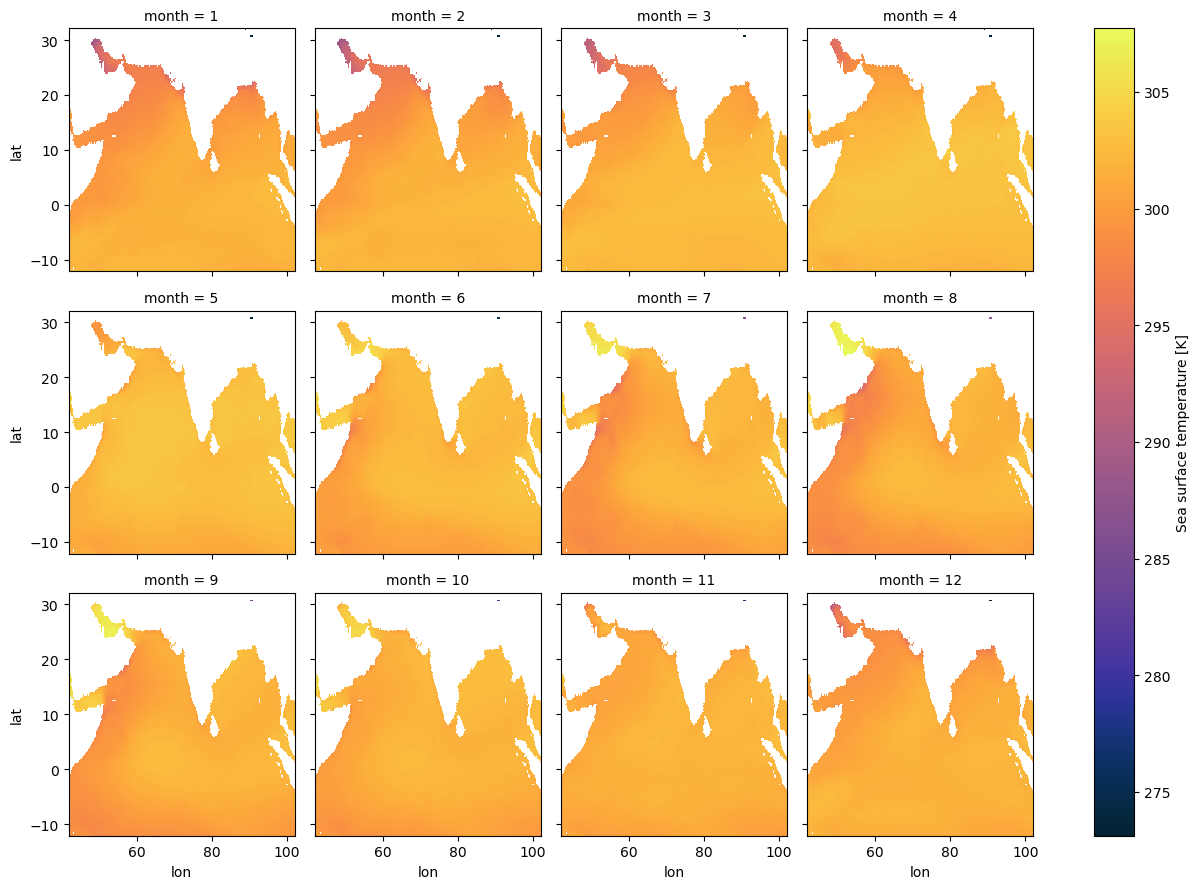

In [60]:
ds_clm.sst.plot(col="month", col_wrap=4, cmap=cmocean.cm.thermal)

In [77]:
ds_clm.v_curr.max().values

array(1.5294565, dtype=float32)

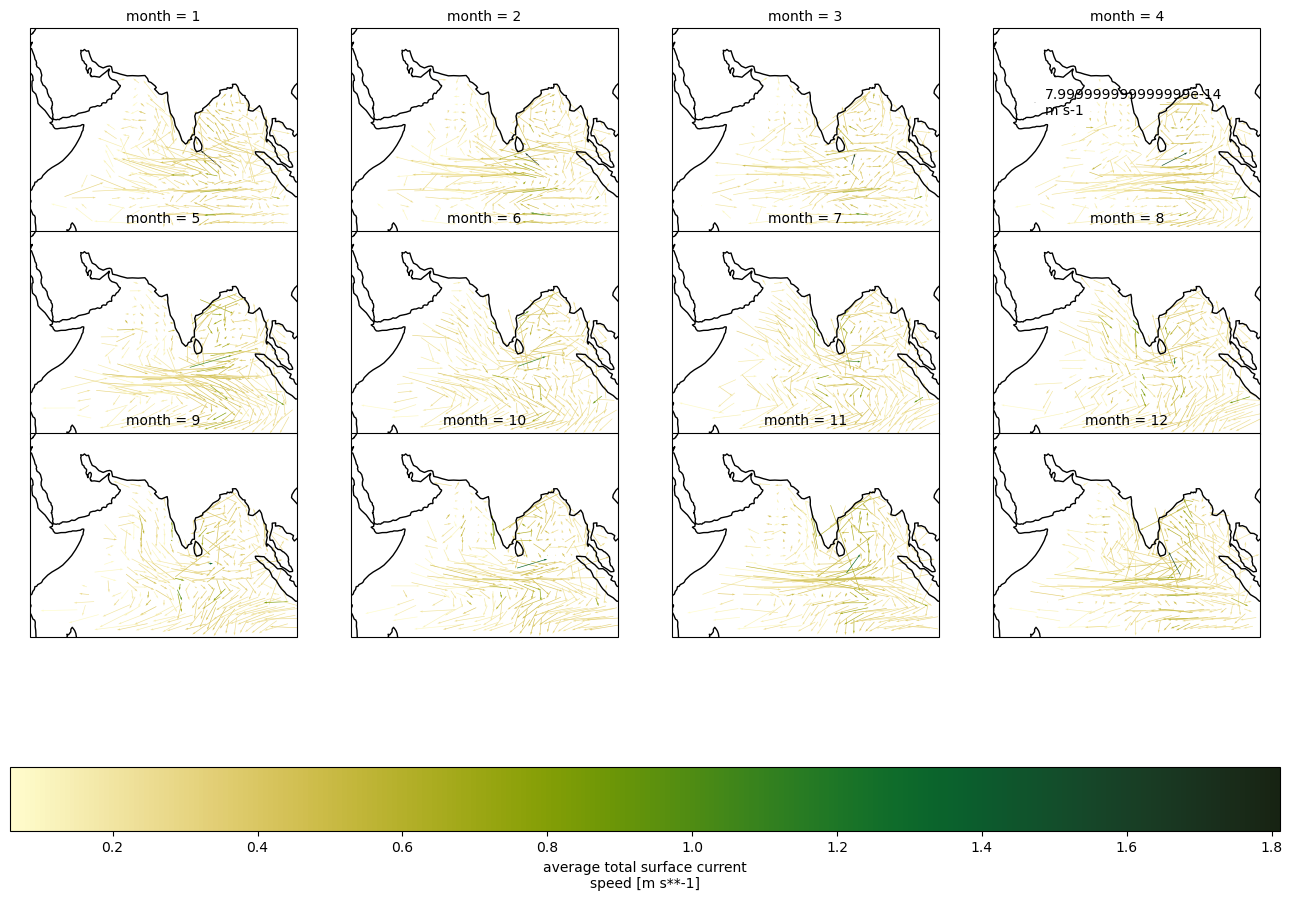

In [65]:
every=8
p = ds_clm.isel(lon=slice(None,None,every), lat=slice(None,None,every)).plot.quiver(x="lon", y="lat", 
            u="u_curr", v="v_curr", 
            hue="curr_speed",
            cmap=cmocean.cm.speed, 
            scale=2, 
            subplot_kws={"projection": projection},
            transform=ccrs.PlateCarree(), 
            cbar_kwargs={"orientation": "horizontal", },
            col="month", col_wrap=4)

[ax.axes.coastlines() for ax in p.axs.flat];

In [33]:
ds_clm["CHL_cmes-gapfree"].hvplot(groupby="month", cnorm="log")

:DynamicMap   [month]
   :Image   [lon,lat]   (CHL_cmes-gapfree)